In [ ]:
import pickle
import random
import numpy as np
from scipy import io
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as tnnf
from tqdm.notebook import tqdm

ms = 1e-3 # use this constant so you can write e.g. 1*ms for a time

Step 1: Simulated Data Generation

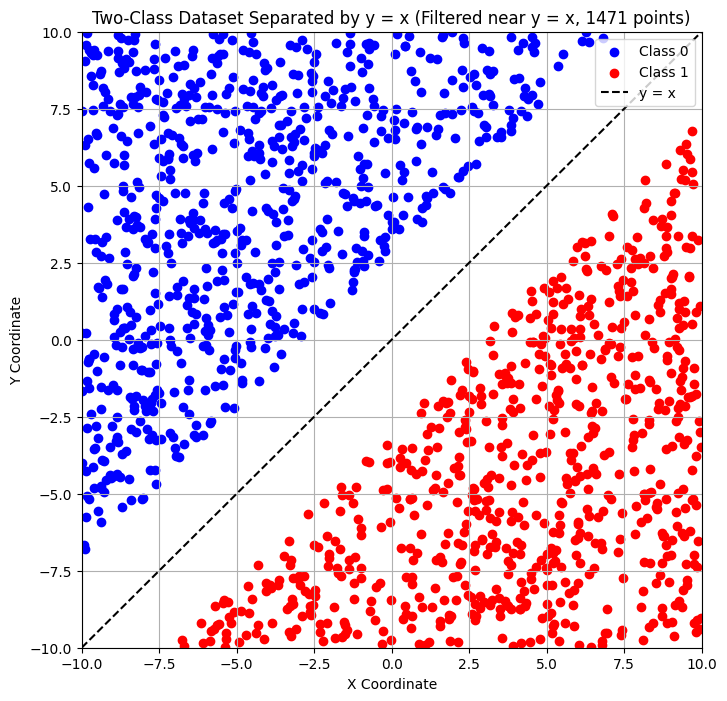

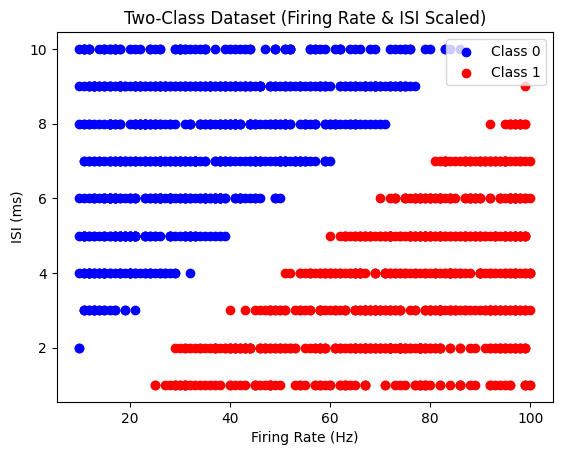

In [3]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


# Number of points per class
num_points = 2000  # Increase if you want more total points
radius = 10        # half side of the square [-10,10]x[-10,10]
min_distance = 2   # Minimum distance threshold from the line y = x

# 1. Generate random points within a square [-radius, radius]^2
X = np.random.uniform(low=-radius, high=radius, size=(num_points, 2))

# 2. Compute the distance of points to the line y = x
distances = np.abs(X[:, 1] - X[:, 0]) / np.sqrt(2)

# 3. Filter points that satisfy the distance condition
valid_indices = distances >= min_distance
X = X[valid_indices]
num_valid_points = X.shape[0]

# 4. Classify points based on y = x
y = np.where(X[:, 1] > X[:, 0], 0, 1)  # Class 0 if y>x, else Class 1

# 5. Visualize the generated data
plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')

# plot line y=x
plt.plot([-radius, radius], [-radius, radius], color='black', linestyle='--', label='y = x')

plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f'Two-Class Dataset Separated by y = x (Filtered near y = x, {num_valid_points} points)')
plt.legend()
plt.grid()
plt.show()

# Map to the integer coordinate range
def linear_map_to_integer(value, old_min, old_max, new_min, new_max):
    mapped = np.round((value - old_min) / (old_max - old_min) * (new_max - new_min) + new_min)
    return np.clip(mapped, new_min, new_max).astype(int)

# Map to specified ranges: firing rate [1, 50] Hz and ISI [1, 50] ms
X_min = X.min(axis=0)
X_max = X.max(axis=0)
firing_rates = linear_map_to_integer(X[:, 0], X_min[0], X_max[0], 10, 100)  # Hz
isis = linear_map_to_integer(X[:, 1], X_min[1], X_max[1], 1, 10)          # ms

# Visualize the data distribution in the mapped range
plt.scatter(firing_rates[y == 0], isis[y == 0], color='blue', label='Class 0')
plt.scatter(firing_rates[y == 1], isis[y == 1], color='red', label='Class 1')
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('ISI (ms)')
plt.legend()
plt.title('Two-Class Dataset (Firing Rate & ISI Scaled)')
plt.show()


Generate dataset and save as .mat

In [ ]:
T = 1000            
num_neurons = 10     
max_attempts = 100   

def generate_spike_train(f, isi, num_neurons, T=1000, max_attempts=100):
    spike_trains = np.zeros((num_neurons, T), dtype=int)  # (num_neurons, T)

    for neuron_idx in range(num_neurons):
        total_spikes = int(round(f) * T / 1000)  # f Hz => f spikes/s => f*(T/1000) spikes in T ms
        if total_spikes % 2 != 0:
            total_spikes += 1

        pairs = total_spikes // 2
        isi_steps = max(1, int(round(isi)))

        occupied_times = set()
        for _ in range(pairs):
            placed = False
            for _ in range(max_attempts):
                start_t = np.random.randint(0, T - isi_steps)
                if all(t not in occupied_times for t in range(start_t - isi_steps, start_t + isi_steps + 1)):
                    spike_trains[neuron_idx, start_t] = 1
                    spike_trains[neuron_idx, start_t + isi_steps] = 1
                    for conflict_t in range(start_t - isi_steps, start_t + isi_steps + 1):
                        occupied_times.add(conflict_t)
                    placed = True
                    break
            if not placed:
                pass

    return spike_trains

N = len(firing_rates)  
spike_trains_per_sample = []
for i in range(N):
    f_val = firing_rates[i]
    isi_val = isis[i]
    spike_trains = generate_spike_train(f_val, isi_val, num_neurons, T=T, max_attempts=max_attempts)
    spike_trains_per_sample.append(spike_trains)

spike_trains_per_sample = np.array(spike_trains_per_sample)  # (N, num_neurons, T)
print(f"Spike Trains Shape: {spike_trains_per_sample.shape}")

data_dict = {
    'X': spike_trains_per_sample,
    'Y': y,
    'firing_rates': firing_rates,
    'isis': isis
}

sio.savemat('spikedataset.mat', data_dict)
print("Data have been saved in spikedataset.mat")

Spike Trains Shape: (1471, 10, 1000)
数据已成功保存到 spikedataset.mat！


X shape = (1471, 10, 1000), Y shape = (1471,)
Selected sample indices: [926 204 736 977]


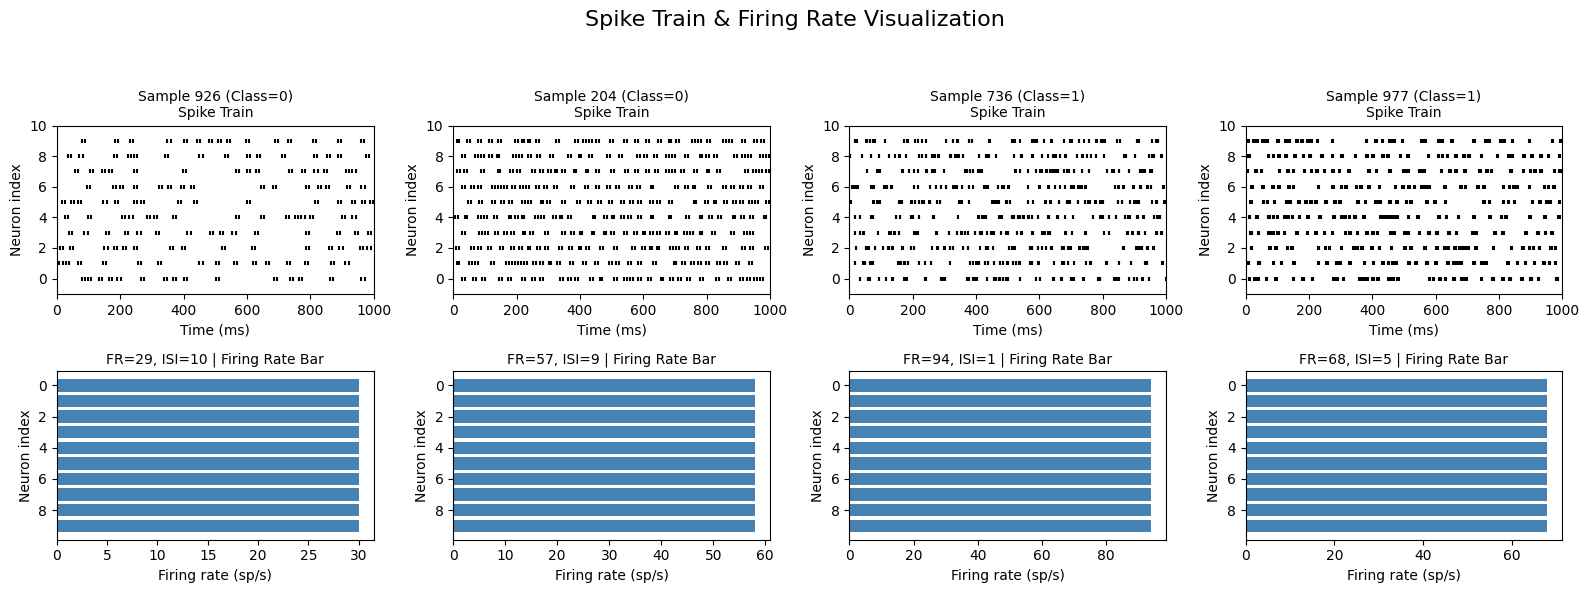

In [ ]:
data = io.loadmat('spikedataset.mat')
X = data['X']  # (N, num_neurons, T)
Y = data['Y'].ravel()  # (N,)
firing_rates_all = data['firing_rates'].ravel()  # (N,)
isis_all = data['isis'].ravel()  # (N,)

N, num_neurons, T = X.shape
print(f"X shape = {X.shape}, Y shape = {Y.shape}")

class0_indices = np.where(Y == 0)[0]
class1_indices = np.where(Y == 1)[0]

num_samples_per_class = 2
selected_class0 = np.random.choice(class0_indices, size=num_samples_per_class, replace=False)
selected_class1 = np.random.choice(class1_indices, size=num_samples_per_class, replace=False)

selected_indices = np.concatenate([selected_class0, selected_class1])
print("Selected sample indices:", selected_indices)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=False, sharey=False)
fig.suptitle("Spike Train & Firing Rate Visualization", fontsize=16)

for col_i, sample_idx in enumerate(selected_indices):
    spike_mat = X[sample_idx, :, :]

    ax_spike = axes[0, col_i]
    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_mat[neuron_idx] == 1)[0]
        ax_spike.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                         s=5, marker='|', color='k')
    ax_spike.set_title(
        f"Sample {sample_idx} (Class={Y[sample_idx]})\nSpike Train",
        fontsize=10
    )
    ax_spike.set_xlim([0, T])
    ax_spike.set_ylim([-1, num_neurons])
    ax_spike.set_xlabel("Time (ms)")
    ax_spike.set_ylabel("Neuron index")

    ax_fr = axes[1, col_i]


    spikes_per_neuron = spike_mat.sum(axis=1)  
    fr_each_neuron = spikes_per_neuron.astype(float)

    y_positions = np.arange(num_neurons)  # 0 ~ num_neurons-1
    ax_fr.barh(y_positions, fr_each_neuron, color='steelblue')


    ax_fr.invert_yaxis()
    fr_val = firing_rates_all[sample_idx]
    isi_val = isis_all[sample_idx]
    ax_fr.set_title(
        f"FR={fr_val}, ISI={isi_val} | Firing Rate Bar",
        fontsize=10
    )

    ax_fr.set_xlabel("Firing rate (sp/s)")
    ax_fr.set_ylabel("Neuron index")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [6]:
def partial_randomize_spike_train(spike_train, f=0.5, max_attempts=50):
    """
    对单个 spike_train (num_neurons, T) 做部分随机化。
    f∈[0,1]：随机化比例，越大 => 越多 spike 重新随机放置时间。
    """
    num_neurons, T = spike_train.shape
    new_train = np.zeros_like(spike_train)
    for neuron_idx in range(num_neurons):
        spike_times = np.where(spike_train[neuron_idx] == 1)[0]
        for old_t in spike_times:
            if np.random.rand() < f:
                placed = False
                for _ in range(max_attempts):
                    new_t = np.random.randint(0, T)
                    if new_train[neuron_idx, new_t] == 0:
                        new_train[neuron_idx, new_t] = 1
                        placed = True
                        break
            else:
                new_train[neuron_idx, old_t] = 1

    return new_train

def partial_randomize_dataset(spike_trains_dataset, f=0.5, max_attempts=50):
    """
    对整个数据集 (N, num_neurons, T) 做部分随机化，返回新数组。
    """
    N, num_neurons, T = spike_trains_dataset.shape
    new_dataset = np.zeros_like(spike_trains_dataset)
    for i in range(N):
        new_dataset[i] = partial_randomize_spike_train(spike_trains_dataset[i], f=f, max_attempts=max_attempts)
    return new_dataset

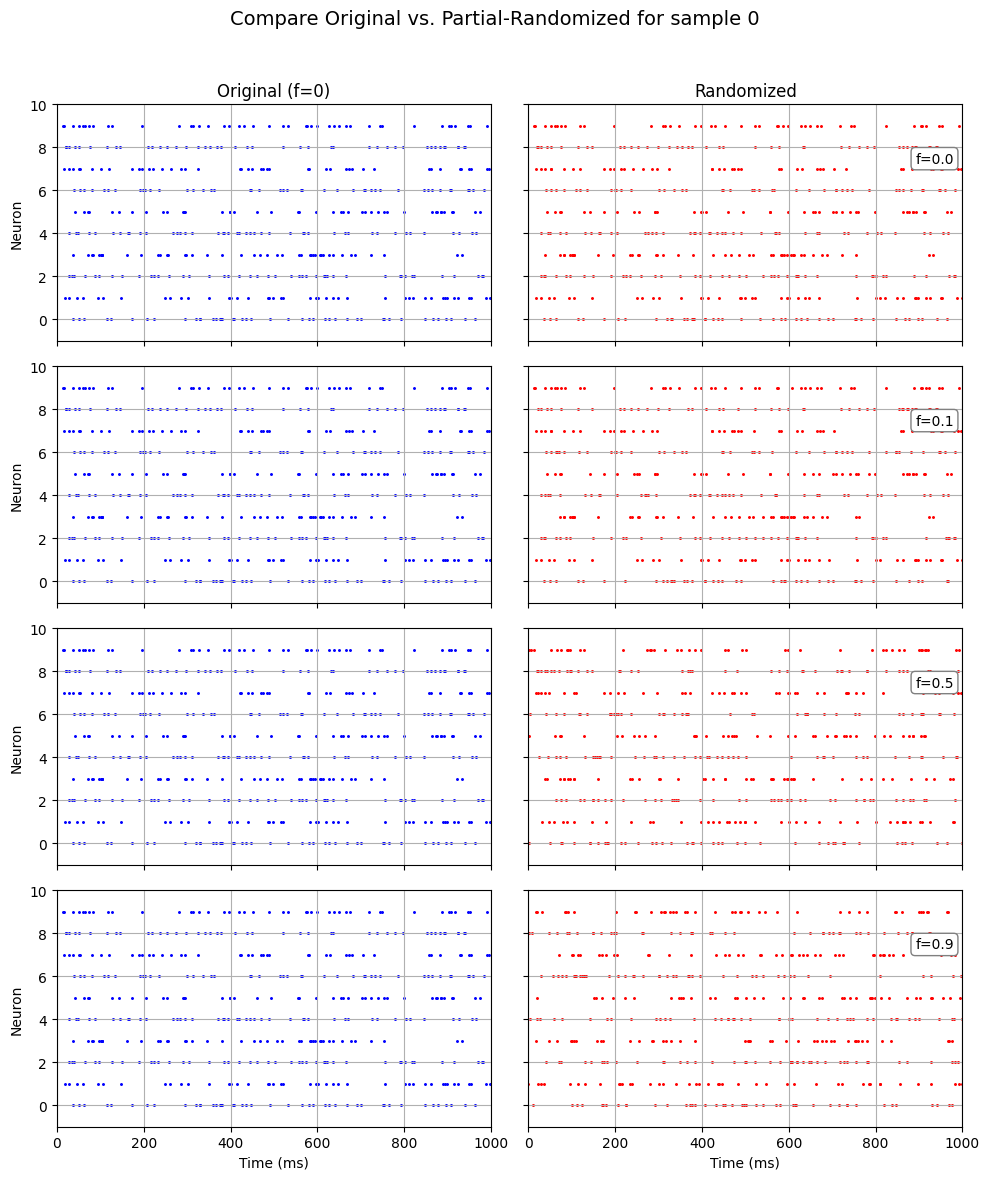

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 选定一个样本的索引
sample_idx = 0  

# 选定 f 值
f_values = [0.0, 0.1, 0.5, 0.9]  # f=0 代表原始数据

# 取出原始 spike train
original_st = X[sample_idx]  # shape (num_neurons, T)

# 创建子图
fig, axes = plt.subplots(len(f_values), 2,
                         figsize=(10, 3 * len(f_values)),
                         sharex=True, sharey=True)
fig.suptitle(f"Compare Original vs. Partial-Randomized for sample {sample_idx}", fontsize=14)

# 逐个绘制不同 f 的对比
for row_i, f in enumerate(f_values):
    # (A) 左列：始终画原始数据（f=0），用于对照
    ax_left = axes[row_i, 0]
    for neuron_idx in range(original_st.shape[0]):
        spike_times = np.where(original_st[neuron_idx] == 1)[0]
        ax_left.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                        s=5, color='b', marker='.')
    ax_left.set_ylabel('Neuron')
    if row_i == 0:
        ax_left.set_title("Original (f=0)")

    # (B) 右列：画 f>0 的随机化 spike train
    randomized_st = partial_randomize_spike_train(original_st, f=f)
    ax_right = axes[row_i, 1]
    for neuron_idx in range(randomized_st.shape[0]):
        spike_times = np.where(randomized_st[neuron_idx] == 1)[0]
        ax_right.scatter(spike_times, np.ones_like(spike_times) * neuron_idx,
                         s=5, color='r', marker='.')
    if row_i == 0:
        ax_right.set_title("Randomized")
    ax_right.text(0.98, 0.8, f"f={f:.1f}", transform=ax_right.transAxes,
                  ha='right', va='top', fontsize=10,
                  bbox=dict(boxstyle="round", fc="white", ec="gray"))

    # 统一设置网格 & 轴范围
    for ax in (ax_left, ax_right):
        ax.set_ylim([-1, original_st.shape[0]])
        ax.set_xlim([0, original_st.shape[1]])
        ax.grid(True)

# 设置 X 轴标签
axes[-1, 0].set_xlabel('Time (ms)')
axes[-1, 1].set_xlabel('Time (ms)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Step 2: Split Dataset and Define Help Function

In [ ]:
num_neurons = X.shape[1]          # 10
total_samples = X.shape[0]        

training_range   = (0, 0.6)   
validation_range = (0.6, 0.75)
testing_range    = (0.75, 0.9)

def num_batches_if(time_fractions, batch_size=8, max_num_batches=None):
    f_start, f_end = time_fractions
    N = X.shape[0] 
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    subX = X[start_idx:end_idx]  # [samples, num_neurons, T]
    sub_len = len(subX)  # end_idx - start_idx
    num_batches = sub_len // batch_size  
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)
    return num_batches

# This is the main generator function
# verbose option to print out some statistics
def batched_data(time_fractions, batch_size=8, verbose=False, max_num_batches=None):
    f_start, f_end = time_fractions
    N = X.shape[0]  
    start_idx = int(round(N * f_start))
    end_idx   = int(round(N * f_end))
    subX = X[start_idx:end_idx]  # [samples, num_neurons, T]
    subY = Y[start_idx:end_idx]  # [samples,]

    sub_len = len(subX)  # end_idx - start_idx
    if sub_len < 1:
        raise ValueError(f"在范围[{start_idx}, {end_idx})没有可用数据。")
    num_time_points = subX.shape[2]
    num_batches = sub_len // batch_size  
    if max_num_batches is not None:
        num_batches = min(num_batches, max_num_batches)

    if verbose:
        print(f"Using data index range = [{start_idx}, {end_idx}), total {sub_len} samples")
        print(f"{batch_size=}")
        print(f"{num_time_points=}")
        print(f'{num_batches=}')
        print(f"RAM usage per batch ~ {batch_size * num_time_points * num_neurons * 8 / (1024)**3:.4f} GB")

    perm = torch.randperm(sub_len)
    idx_start = 0
    for _ in range(num_batches):

        idx_end = idx_start + batch_size
        batch_indices = perm[idx_start:idx_end]
        idx_start = idx_end
        x_out = torch.zeros((batch_size, num_neurons, num_time_points))
        y_out = torch.zeros((batch_size,))
        for b in range(batch_size):
            real_idx = batch_indices[b].item()
            x_out[b] = torch.from_numpy(subX[real_idx])  # (num_neurons, T)
            y_out[b] = torch.tensor(subY[real_idx])    
        yield x_out, y_out

Step 2: Build the Spiking Neural Network Model (SNN)

In [11]:
class SurrogateHeaviside(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrogateHeaviside.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrogateHeaviside" nonlinearity which implements a surrogate gradient
surrogate_heaviside  = SurrogateHeaviside.apply

In [12]:
################### SOLUTION #####################
class SNNLayer(nn.Module):
  def __init__(self, n_in, n_out, spiking=True, **params):
    super(SNNLayer, self).__init__()
    self.n_in = n_in
    self.n_out = n_out
    # Store weights as a trainable parameter
    self.w = nn.Parameter(torch.ones((n_in, n_out)))
    self.spiking = spiking
    # Parameters for the underlying neuron model
    # You can either set tau in which case alpha=exp(-dt/tau)
    # or you can directly set alpha (in which case tau and dt ignored)
    # This dictionary gives the default values which can be overrided
    # by the user specified parameters
    self.params = dict(
        tau = 20*ms,
        alpha = None,
        dt = 1*ms,
        )
    self.params.update(**params)

  def forward(self, x):
    batch_size, num_neurons, num_time_points = x.shape
    assert num_neurons==self.n_in
    v = torch.zeros((batch_size, self.n_out)) # membrane potential
    s = torch.zeros((batch_size, self.n_out)) # spiking
    if self.params['alpha'] is not None:
      alpha = self.params['alpha']
    else:
      alpha = np.exp(-self.params['dt']/self.params['tau'])
    h = torch.einsum('bit,ij->bjt', (x, self.w))
    # Do we want spiking or non-spiking output?
    if self.spiking:
      rec = [s]
    else:
      rec = [v]
    for t in range(num_time_points-1):
      new_v = (v*alpha+h[:, :, t])
      # handle two possible cases of spiking or no spiking
      if self.spiking:
        new_v = new_v*(1-s)
        s = surrogate_heaviside(v-1)
      v = new_v
      if self.spiking:
        rec.append(s)
      else:
        rec.append(v)
    y = torch.stack(rec, dim=2)
    return y

# This is just a very simple (non-Pytorch) class that generates a chain of layers connected
# to each other. You should probably use torch.nn.Sequential instead but I was in a hurry.
class MultilayerSNN:
  def __init__(self, layer_sizes, params):
    assert layer_sizes[0]==num_neurons and layer_sizes[-1]==2
    assert len(layer_sizes)-1==len(params)
    self.layer_sizes = layer_sizes
    self.params = params
    self.num_layers = len(layer_sizes)-1
    self.networks = []
    self.parameters = []
    for n_in, n_out, p in zip(layer_sizes[:-1], layer_sizes[1:], params):
      net = SNNLayer(n_in, n_out, **p)
      # net = torch.compile(net) # this doesn't work on windows but might speed up on linux
      # Uniform initialisation works well
      nn.init.uniform_(net.w, *p['w_init'])
      # You could also try normal or truncated normal initialisation
      # nn.init.normal_(net.w, *p['w_init'])
      # nn.init.trunc_normal_(net.w, *p['w_init'])
      self.networks.append(net)
      self.parameters.append(net.w)

  def __call__(self, x, record=False):
    rec = []
    for net in self.networks:
      if net.n_out==2:
        x = net(x)
      else:
        x = net(x)
      if record:
        rec.append(x)
    if record:
      return x, rec
    else:
      return x

In [ ]:
import torch.nn.functional as F

def evaluate_network(net, *args, **kwds):
    # args and kwds are passed to batched data
    losses = []
    null_losses = []
    with torch.no_grad():
        for x, y in batched_data(*args, **kwds):
            y_out = net(x)
            y_out_final = y_out[:, :, -1]   # shape (b, 2)
            loss = F.cross_entropy(y_out_final, y.long())
            zero_logits = torch.zeros_like(y_out_final)
            null_loss = F.cross_entropy(zero_logits, y.long())
            losses.append(loss.item())
            null_losses.append(null_loss.item())
    return np.mean(losses), np.mean(null_losses)

# Debug network figure
def debug_figure(net):
  plt.figure(figsize=(10, 4))
  with torch.no_grad():
    for x, y in batched_data(testing_range, batch_size=1,max_num_batches=1):
      _, rec = net(x, record=True)
      rec = [x]+rec
      for i, x in enumerate(rec):
        plt.subplot(2, len(rec), i+1)
        plt.imshow(x[0, :, :], aspect='auto', origin='lower', cmap='gray_r' if i<len(rec)-1 else 'viridis')
        if i==len(rec)-1:
          plt.title('output')
          plt.colorbar()
        elif i==0:
          plt.title('input data')
        else:
          plt.title(f'layer = {i}')
        if i<len(rec)-1:
          plt.subplot(2, len(rec), i+1+len(rec))
          firing_rates = x[0, :, :].sum(axis=1)
          mean_firing_rate = firing_rates.mean()
          plt.bar(range(len(firing_rates)), firing_rates, width=1)
          plt.axhline(mean_firing_rate, ls='--', c='r')
          plt.title(f'mean FR = {mean_firing_rate:.1f} sp/s')
  plt.tight_layout();

  0%|          | 0/270 [00:00<?, ?it/s]

Using data index range = [0, 883), total 883 samples
batch_size=32
num_time_points=1000
num_batches=27
RAM usage per batch ~ 0.0024 GB


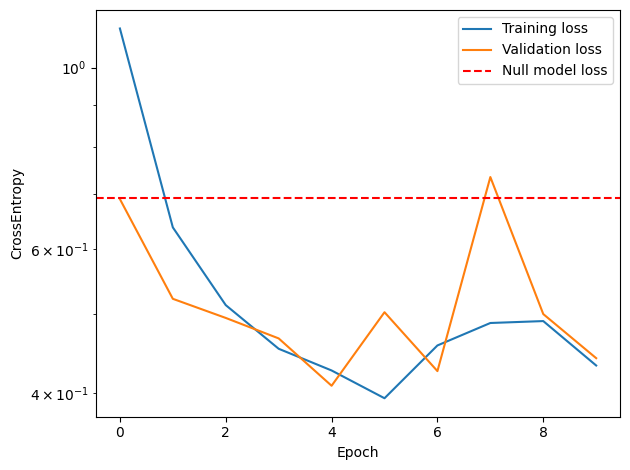

test_loss=0.3649, null_test_loss=0.6931


In [16]:
net = MultilayerSNN((num_neurons, 100, 2),
                    [
                      dict(tau=50*ms, w_init=(-0.5, 0.7)),
                      dict(tau=500*ms, spiking=False, w_init=(-0.01, 0.01)),
                    ])

data = io.loadmat('spikedataset.mat')
X = data['X']  # (N, num_neurons, T)
X = partial_randomize_dataset(X, f=0.9)

# Training parameters
lr = 0.001 # learning rate
num_epochs = 10
max_num_batches = 40
batch_size = 32

# Optimiser and loss function
optimizer = torch.optim.Adam(net.parameters, lr=lr)

# Training
loss_hist = []
val_loss_hist = []

with tqdm(total=num_epochs*num_batches_if(training_range,batch_size=batch_size,max_num_batches=max_num_batches)) as pbar:
  last_epoch_loss = val_loss = null_val_loss = None
  for epoch in range(num_epochs):
    local_loss = []
    for x, y in batched_data(training_range, batch_size=batch_size, max_num_batches=max_num_batches,verbose=(epoch==0)):
      y_out = net(x)                 # (b, 2, T)
      y_out_final = y_out[:, :, -1]  # => (b, 2)
      loss = F.cross_entropy(y_out_final, y.long())
      local_loss.append(loss.item())
      # Update gradients
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      pbar.update(1)
      pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
    last_epoch_loss = np.mean(local_loss)
    val_loss, null_val_loss = evaluate_network(net, validation_range, batch_size=batch_size)
    pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
    loss_hist.append(last_epoch_loss)
    val_loss_hist.append(val_loss)

plt.figure()
plt.semilogy(loss_hist, label='Training loss')
plt.semilogy(val_loss_hist, label='Validation loss')
plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

test_loss, null_test_loss = evaluate_network(net, testing_range, batch_size=batch_size)
print(f"test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")


In [ ]:
# I use this to save a copy of a good network if I find one
if 0:
    torch.save(net, 'good_f09.pt')

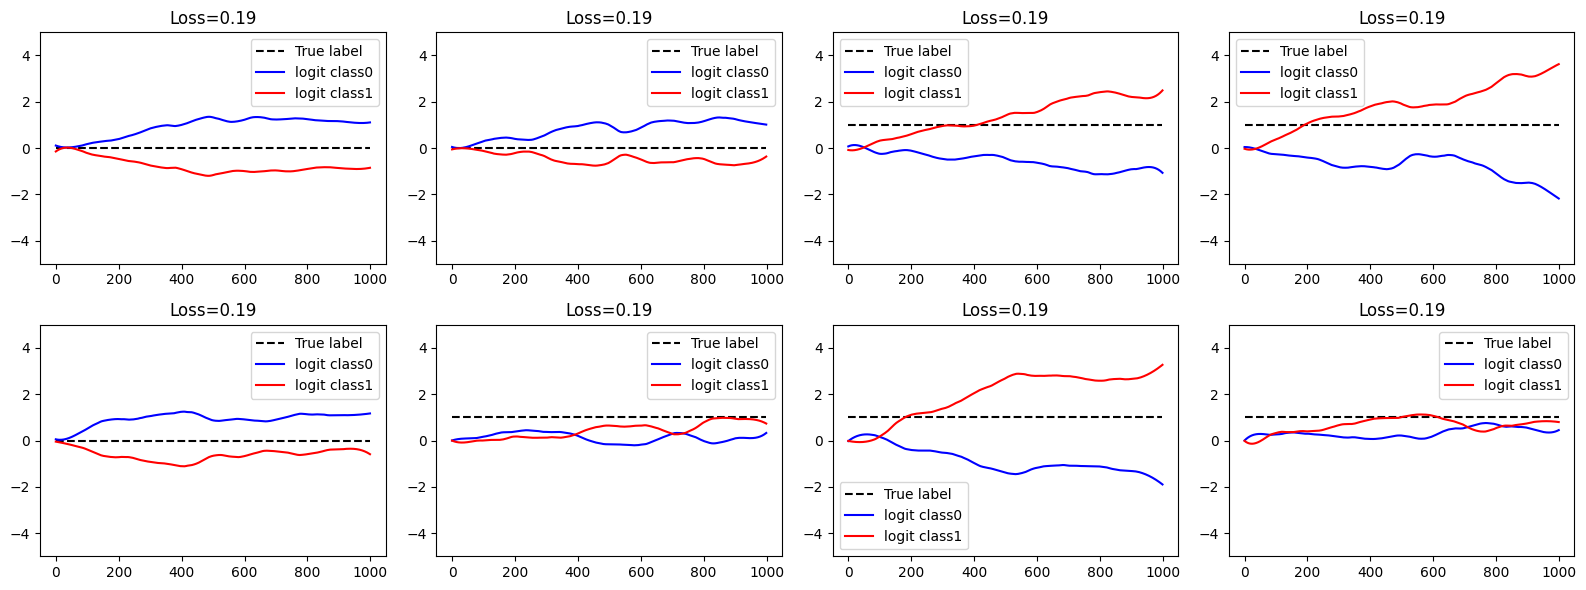

Test Accuracy = 82.81%


In [22]:
# Test trained output
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(16, 6))

with torch.no_grad():
    for x, y in batched_data(testing_range, batch_size=8, max_num_batches=1):
        y_out = net(x)  # y_out.shape = (8, 2, T)
        y_out_final = y_out[:, :, -1]  
        loss = F.cross_entropy(y_out_final, y.long())

        T_show = x.shape[2]
        for b in range(8):
            plt.subplot(2, 4, b + 1)

            label_line = [y[b].item()] * T_show
            plt.plot(label_line, '--k', label='True label')

            if T_show >= 151:
                class0_curve = savgol_filter(y_out[b, 0, :], 151, 3)
                class1_curve = savgol_filter(y_out[b, 1, :], 151, 3)
            else:
                class0_curve = y_out[b, 0, :].cpu().numpy()
                class1_curve = y_out[b, 1, :].cpu().numpy()

            plt.plot(class0_curve, '-b', label='logit class0')
            plt.plot(class1_curve, '-r', label='logit class1')
            plt.ylim(-5, 5)
            plt.title(f"Loss={loss.item():.2f}")
            plt.legend(loc='best')

plt.tight_layout()
plt.show()

def test_accuracy(net, time_fractions, batch_size=8, max_num_batches=None):

    total_samples = 0
    correct_samples = 0

    with torch.no_grad():
        for x, y in batched_data(time_fractions, batch_size=batch_size, max_num_batches=max_num_batches):
            y_out = net(x)               # shape (b,2,T)
            y_out_final = y_out[:, :, -1]  # shape (b,2)

            preds = torch.argmax(y_out_final, dim=1)
            correct_samples += (preds == y).sum().item()
            total_samples   += y.shape[0]

    acc = correct_samples / total_samples if total_samples>0 else 0.0
    return acc

test_acc = test_accuracy(net, testing_range, batch_size=128)
print(f"Test Accuracy = {test_acc:.2%}")  

  0%|          | 0/270 [00:00<?, ?it/s]

Using data index range = [0, 883), total 883 samples
batch_size=32
num_time_points=1000
num_batches=27
RAM usage per batch ~ 0.0024 GB


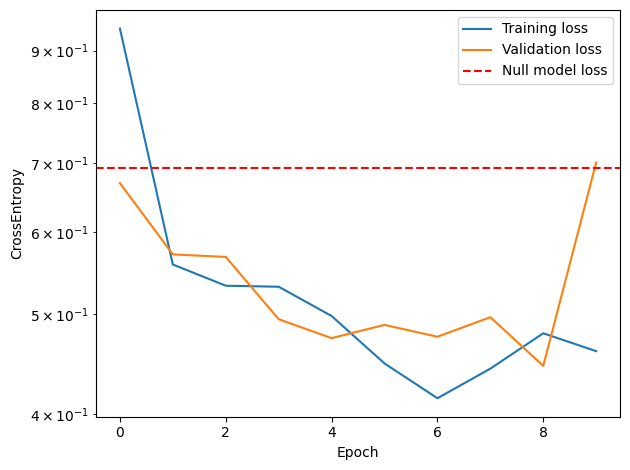

test_loss=0.7343, null_test_loss=0.6931


In [27]:
net = MultilayerSNN((num_neurons, 100, 2),
                    [
                      dict(tau=50*ms, w_init=(-0.5, 0.7)),
                      dict(tau=500*ms, spiking=False, w_init=(-0.01, 0.01)),
                    ])

data = io.loadmat('spikedataset.mat')
X = data['X']  # (N, num_neurons, T)
X = partial_randomize_dataset(X, f=0.5)

# Training parameters
lr = 0.001 # learning rate
num_epochs = 10
max_num_batches = 40
batch_size = 32

# Optimiser and loss function
optimizer = torch.optim.Adam(net.parameters, lr=lr)

# Training
loss_hist = []
val_loss_hist = []

with tqdm(total=num_epochs*num_batches_if(training_range,batch_size=batch_size,max_num_batches=max_num_batches)) as pbar:
  last_epoch_loss = val_loss = null_val_loss = None
  for epoch in range(num_epochs):
    local_loss = []
    for x, y in batched_data(training_range, batch_size=batch_size, max_num_batches=max_num_batches,verbose=(epoch==0)):
      y_out = net(x)                 # (b, 2, T)
      y_out_final = y_out[:, :, -1]  # => (b, 2)
      loss = F.cross_entropy(y_out_final, y.long())
      local_loss.append(loss.item())
      # Update gradients
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      pbar.update(1)
      pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
    last_epoch_loss = np.mean(local_loss)
    val_loss, null_val_loss = evaluate_network(net, validation_range, batch_size=batch_size)
    pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
    loss_hist.append(last_epoch_loss)
    val_loss_hist.append(val_loss)

plt.figure()
plt.semilogy(loss_hist, label='Training loss')
plt.semilogy(val_loss_hist, label='Validation loss')
plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

test_loss, null_test_loss = evaluate_network(net, testing_range, batch_size=batch_size)
print(f"test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")


In [28]:
# I use this to save a copy of a good network if I find one
if 1:
    torch.save(net, 'good_f05.pt')

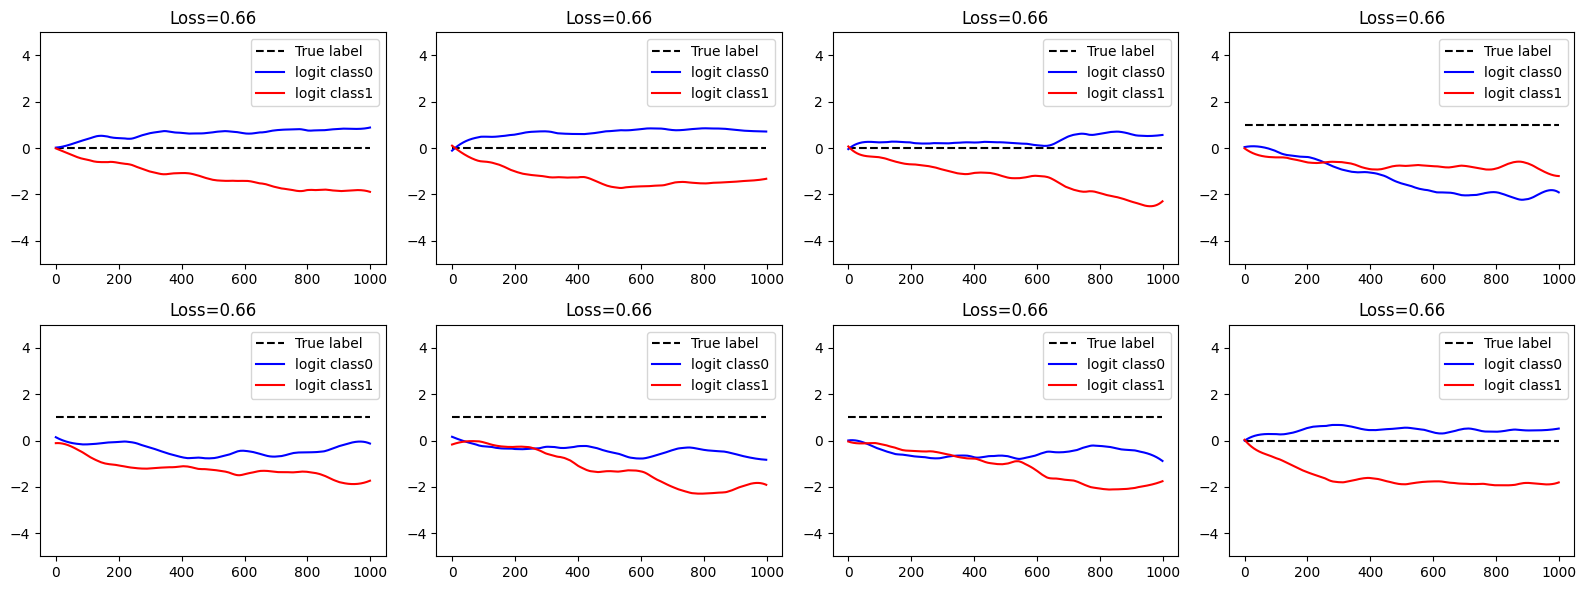

Test Accuracy = 68.75%


In [30]:
# Test trained output
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(16, 6))

with torch.no_grad():
    for x, y in batched_data(testing_range, batch_size=8, max_num_batches=1):
        y_out = net(x)  # y_out.shape = (8, 2, T)
        y_out_final = y_out[:, :, -1]  
        loss = F.cross_entropy(y_out_final, y.long())

        T_show = x.shape[2]
        for b in range(8):
            plt.subplot(2, 4, b + 1)

            label_line = [y[b].item()] * T_show
            plt.plot(label_line, '--k', label='True label')

            if T_show >= 151:
                class0_curve = savgol_filter(y_out[b, 0, :], 151, 3)
                class1_curve = savgol_filter(y_out[b, 1, :], 151, 3)
            else:
                class0_curve = y_out[b, 0, :].cpu().numpy()
                class1_curve = y_out[b, 1, :].cpu().numpy()

            plt.plot(class0_curve, '-b', label='logit class0')
            plt.plot(class1_curve, '-r', label='logit class1')
            plt.ylim(-5, 5)
            plt.title(f"Loss={loss.item():.2f}")
            plt.legend(loc='best')

plt.tight_layout()
plt.show()

def test_accuracy(net, time_fractions, batch_size=8, max_num_batches=None):

    total_samples = 0
    correct_samples = 0

    with torch.no_grad():
        for x, y in batched_data(time_fractions, batch_size=batch_size, max_num_batches=max_num_batches):
            y_out = net(x)               # shape (b,2,T)
            y_out_final = y_out[:, :, -1]  # shape (b,2)

            preds = torch.argmax(y_out_final, dim=1)
            correct_samples += (preds == y).sum().item()
            total_samples   += y.shape[0]

    acc = correct_samples / total_samples if total_samples>0 else 0.0
    return acc

test_acc = test_accuracy(net, testing_range, batch_size=128)
print(f"Test Accuracy = {test_acc:.2%}")  

  0%|          | 0/270 [00:00<?, ?it/s]

Using data index range = [0, 883), total 883 samples
batch_size=32
num_time_points=1000
num_batches=27
RAM usage per batch ~ 0.0024 GB


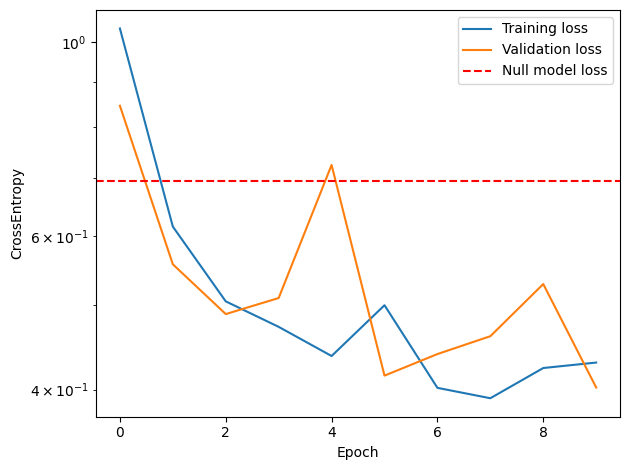

test_loss=0.3513, null_test_loss=0.6931


In [31]:
net = MultilayerSNN((num_neurons, 100, 2),
                    [
                      dict(tau=50*ms, w_init=(-0.5, 0.7)),
                      dict(tau=500*ms, spiking=False, w_init=(-0.01, 0.01)),
                    ])

data = io.loadmat('spikedataset.mat')
X = data['X']  # (N, num_neurons, T)
X = partial_randomize_dataset(X, f=1)

# Training parameters
lr = 0.001 # learning rate
num_epochs = 10
max_num_batches = 40
batch_size = 32

# Optimiser and loss function
optimizer = torch.optim.Adam(net.parameters, lr=lr)

# Training
loss_hist = []
val_loss_hist = []

with tqdm(total=num_epochs*num_batches_if(training_range,batch_size=batch_size,max_num_batches=max_num_batches)) as pbar:
  last_epoch_loss = val_loss = null_val_loss = None
  for epoch in range(num_epochs):
    local_loss = []
    for x, y in batched_data(training_range, batch_size=batch_size, max_num_batches=max_num_batches,verbose=(epoch==0)):
      y_out = net(x)                 # (b, 2, T)
      y_out_final = y_out[:, :, -1]  # => (b, 2)
      loss = F.cross_entropy(y_out_final, y.long())
      local_loss.append(loss.item())
      # Update gradients
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      pbar.update(1)
      pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
    last_epoch_loss = np.mean(local_loss)
    val_loss, null_val_loss = evaluate_network(net, validation_range, batch_size=batch_size)
    pbar.set_postfix(epoch=epoch, last_epoch_loss=last_epoch_loss, loss=loss.item(), val_loss=val_loss, null_val_loss=null_val_loss)
    loss_hist.append(last_epoch_loss)
    val_loss_hist.append(val_loss)

plt.figure()
plt.semilogy(loss_hist, label='Training loss')
plt.semilogy(val_loss_hist, label='Validation loss')
plt.axhline(null_val_loss, ls='--', c='r', label='Null model loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

test_loss, null_test_loss = evaluate_network(net, testing_range, batch_size=batch_size)
print(f"test_loss={test_loss:.4f}, null_test_loss={null_test_loss:.4f}")


In [32]:
# I use this to save a copy of a good network if I find one
if 1:
    torch.save(net, 'good_f10.pt')

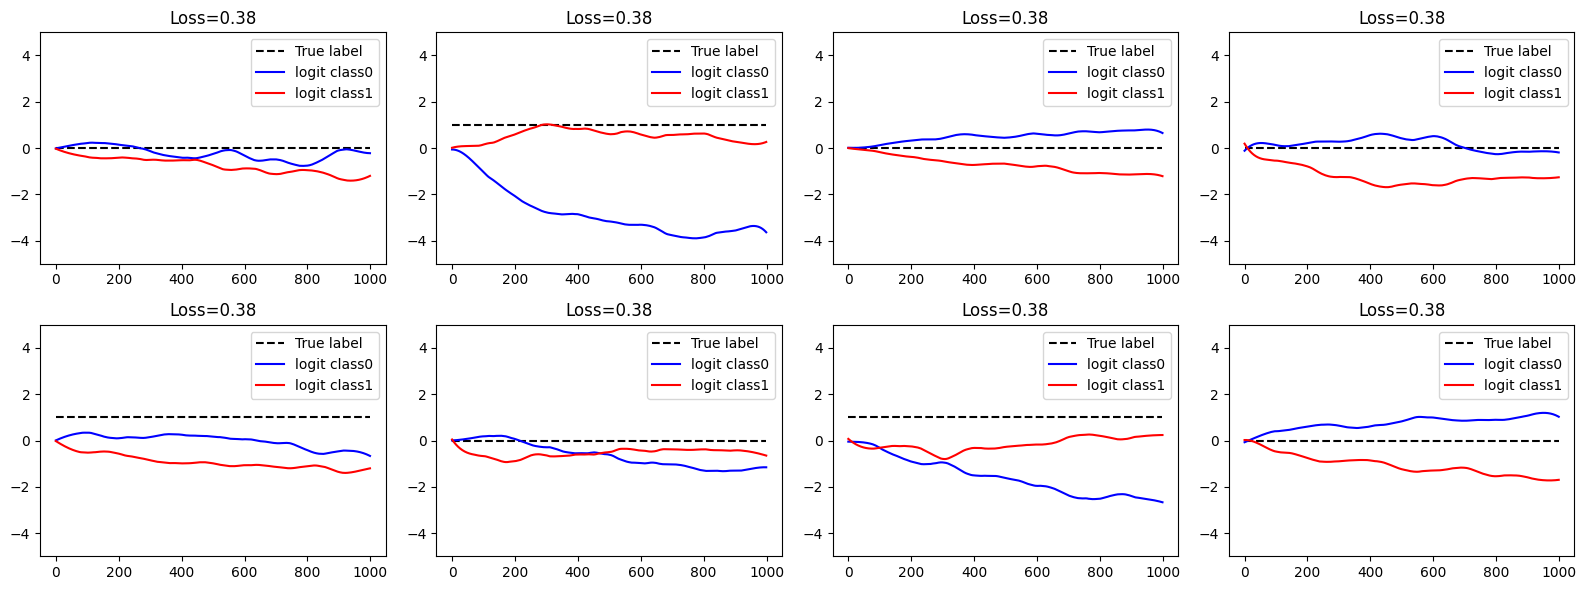

Test Accuracy = 83.59%


In [33]:
# Test trained output
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(16, 6))

with torch.no_grad():
    for x, y in batched_data(testing_range, batch_size=8, max_num_batches=1):
        y_out = net(x)  # y_out.shape = (8, 2, T)
        y_out_final = y_out[:, :, -1]  
        loss = F.cross_entropy(y_out_final, y.long())

        T_show = x.shape[2]
        for b in range(8):
            plt.subplot(2, 4, b + 1)

            label_line = [y[b].item()] * T_show
            plt.plot(label_line, '--k', label='True label')

            if T_show >= 151:
                class0_curve = savgol_filter(y_out[b, 0, :], 151, 3)
                class1_curve = savgol_filter(y_out[b, 1, :], 151, 3)
            else:
                class0_curve = y_out[b, 0, :].cpu().numpy()
                class1_curve = y_out[b, 1, :].cpu().numpy()

            plt.plot(class0_curve, '-b', label='logit class0')
            plt.plot(class1_curve, '-r', label='logit class1')
            plt.ylim(-5, 5)
            plt.title(f"Loss={loss.item():.2f}")
            plt.legend(loc='best')

plt.tight_layout()
plt.show()

def test_accuracy(net, time_fractions, batch_size=8, max_num_batches=None):

    total_samples = 0
    correct_samples = 0

    with torch.no_grad():
        for x, y in batched_data(time_fractions, batch_size=batch_size, max_num_batches=max_num_batches):
            y_out = net(x)               # shape (b,2,T)
            y_out_final = y_out[:, :, -1]  # shape (b,2)

            preds = torch.argmax(y_out_final, dim=1)
            correct_samples += (preds == y).sum().item()
            total_samples   += y.shape[0]

    acc = correct_samples / total_samples if total_samples>0 else 0.0
    return acc

test_acc = test_accuracy(net, testing_range, batch_size=128)
print(f"Test Accuracy = {test_acc:.2%}")  